# QPT Benchmarking Example

This notebook demonstrates how to use the `benchmarking` package in the Toffoli-Optimization repository to perform QPT with error bounds on any quantum circuit.

In [3]:
import sys
import numpy as np
from qiskit import *
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import qiskit.quantum_info as qi
sys.path.append('..')
from pyquopt import *
from benchmarking import generate_qpt_circuits, run_qpt_job, compute_fidelity, compute_fidelity_job_id, PulseGates, Gates

### Load Credentials and APIs

In [30]:
IBMQ.load_account()
provider = IBMQ.providers()[1]
backend = provider.get_backend('ibm_lagos')

ibmqfactory.load_account:WARNING:2022-03-16 15:53:19,012: Credentials are already in use. The existing account in the session will be replaced.


In [31]:
ss_api_key = ""
ss_host = ""  # not necessary

### Get System Measurement Error

In [32]:
qr = QuantumRegister(7)
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=[[0, 1, 3]], qr=qr, circlabel='mcal')

In [33]:
# meas_cal_job = execute(meas_calibs, backend=backend, optimization_level=0, shots=8192)  # uncomment to run
# print(meas_cal_job.job_id())
meas_cal_job = meas_cal_job = backend.retrieve_job('6230082e314f79ab0520c03d') # calibration data

In [34]:
cal_results = meas_cal_job.result()

In [35]:
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=[[0, 1, 3]])

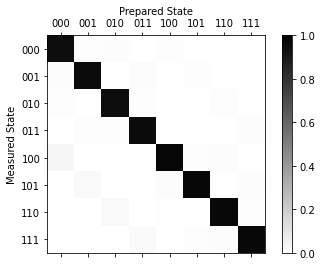

In [36]:
meas_fitter.plot_calibration(0)

In [37]:
meas_filter = meas_fitter.filter

### Get Toffoli Gate Implementations and Unitary

In [38]:
basic_toffoli_circ = QuantumCircuit(3)
basic_toffoli_circ.ccx(0, 1, 2)

# Get the ideal Toffoli gate unitary operator
target_unitary = qi.Operator(basic_toffoli_circ)

In [39]:
target_unitary

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

In [40]:
gate_gen = PulseGates(backend, ss_host, ss_api_key)

In [41]:
gate_gen_gate = Gates(backend)

In [53]:
opt_linear_toffoli = gate_gen.get_optimized_linear_toffoli(qubits=[1, 3, 5], target="ibmq_lagos_qpu")

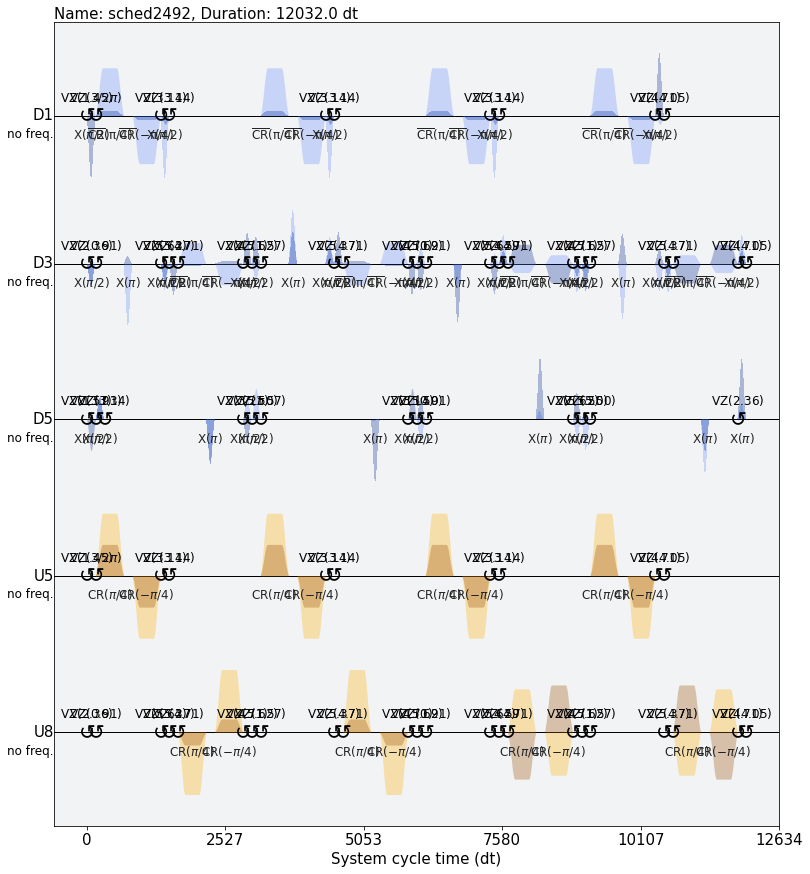

In [54]:
opt_linear_toffoli.draw()

In [51]:
canonical_linear_toffoli = gate_gen.get_canonical_linear_toffoli(qubits=[1, 3, 5])

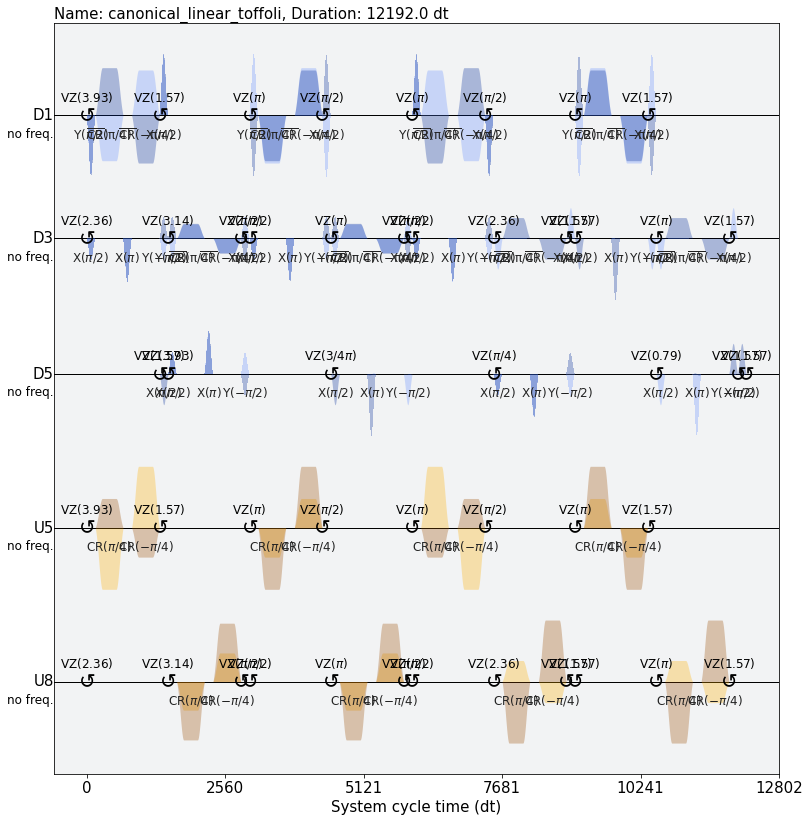

In [52]:
canonical_linear_toffoli.draw()

In [25]:
canonical_linear_toffoli_gate = gate_gen_gate.get_canonical_linear_toffoli(qubits=[0, 1, 3])

In [26]:
canonical_linear_toffoli_gate.draw()

┌───┐                                                        
q_0: ┤ T ├──■─────────■──────────■──────────────────■─────────────
     ├───┤┌─┴─┐     ┌─┴─┐      ┌─┴─┐ ┌─────┐      ┌─┴─┐           
q_1: ┤ T ├┤ X ├──■──┤ X ├──■───┤ X ├─┤ Tdg ├──■───┤ X ├───■───────
     └───┘└───┘  │  └───┘  │   └───┘ └─────┘  │   └───┘   │       
q_2: ────────────┼─────────┼──────────────────┼───────────┼───────
     ┌───┐┌───┐┌─┴─┐┌───┐┌─┴─┐┌─────┐       ┌─┴─┐┌─────┐┌─┴─┐┌───┐
q_3: ┤ H ├┤ T ├┤ X ├┤ T ├┤ X ├┤ Tdg ├───────┤ X ├┤ Tdg ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└─────┘       └───┘└─────┘└───┘└───┘
q_4: ─────────────────────────────────────────────────────────────
                                                                  
q_5: ─────────────────────────────────────────────────────────────
                                                                  
q_6: ─────────────────────────────────────────────────────────────

### Generate and Run QPT Circuits

In [27]:
# circuit = QuantumCircuit(7)
# circuit.ccx(0, 1, 3)

# qpt_circuits = generate_qpt_circuits(circuit=circuit, qubits=[0, 1, 3], backend=backend)
# transpiled_qpt_circuits = []

# for qpt_circuit in qpt_circuits:
#     qpt_circuit.add_calibration('ccx', [0, 1, 3], canonical_linear_toffoli)
#     transpiled_qpt_circuit = transpile(qpt_circuit, backend=backend)
#     transpiled_qpt_circuits.append(transpiled_qpt_circuit)

In [28]:
qpt_circuits = generate_qpt_circuits(circuit=canonical_linear_toffoli_gate, qubits=[0, 1, 3], backend=backend)

transpiled_qpt_circuits = []

for qpt_circuit in qpt_circuits:
    # qpt_circuit.add_calibration('ccx', [0, 1, 3], canonical_linear_toffoli)
    transpiled_qpt_circuit = transpile(qpt_circuit, backend=backend)
    transpiled_qpt_circuits.append(transpiled_qpt_circuit)

/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/maxab/anaconda3/envs/micro/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circ

In [31]:
# job_id = run_qpt_job(qpt_circuits=transpiled_qpt_circuits, provider=provider, backend=backend, shots=8192, job_name="benchmark_standard_gate_3_15_22")

In [32]:
job_id = ""

### Analyze Results

In [33]:
avg_fidelity, error_bound = compute_fidelity_job_id(qpt_circuits=transpiled_qpt_circuits,
                                                    provider=provider,
                                                    qpt_result_job_id=job_id,
                                                    meas_filter=meas_filter,
                                                    target_unitary=target_unitary,
                                                    mc_trials=100)

Trial 0: 0.859365721438425
Trial 1: 0.8601533674781622
Trial 2: 0.8596426062719782
Trial 3: 0.8606974297281825
Trial 4: 0.8608798532894422
Trial 5: 0.860792228517385
Trial 6: 0.8612840798671518
Trial 7: 0.8621231440089923
Trial 8: 0.8624941799027442
Trial 9: 0.8608398750006087
Trial 10: 0.8603363248095827
Trial 11: 0.8611126625752032
Trial 12: 0.8617640583078386
Trial 13: 0.860093851811951
Trial 14: 0.8618705542606766
Trial 15: 0.8622295067248691
Trial 16: 0.8595996688848095
Trial 17: 0.8596083239173251
Trial 18: 0.8608333921728752
Trial 19: 0.8604853277830166
Trial 20: 0.8607942982280267
Trial 21: 0.8614085204120929
Trial 22: 0.8600735148079186
Trial 23: 0.8617834312411259
Trial 24: 0.8608378011959582
Trial 25: 0.8612601520916162
Trial 26: 0.861187920395824
Trial 27: 0.8610620484903505
Trial 28: 0.8604064309440533
Trial 29: 0.8599772360600448
Trial 30: 0.8607681729925363
Trial 31: 0.8617064312939473
Trial 32: 0.8606954864684992
Trial 33: 0.8605574673640143
Trial 34: 0.8593342470483774

In [34]:
print(f"Average fidelity is {avg_fidelity} +/- {error_bound}.")

Average fidelity is 0.8607803834547838 +/- 0.0015096883870850967.
